In [30]:
# Laura Guo
# 22 June 2020
# This is the 1D maze example discussed in the 6/17/20 meeting, but modified to use a neural network and HRRs.

import random
import hrr
import keras
import numpy as np
import matplotlib.pyplot as plt

# environment initialization
maze_len = 20
gamma = 1 # used in the value function
epsilon = 0.03

reward_state = random.randint(0, maze_len - 1) # location of the reward
reward = [-1] * maze_len # reward function
reward[reward_state] = 0
maze = [''] * maze_len # visual representation of where the agent and reward are
maze[reward_state] = 'R'

# agent initialization
hrr_len = 1024
ltm = hrr.LTM(N = hrr_len)
lr = 0.01

# neural network initialization
model = keras.Sequential()
model.add(keras.layers.Dense(1, activation = "linear", input_shape = [hrr_len], use_bias = False))
model.compile(loss = keras.losses.mse, optimizer = keras.optimizers.SGD(lr = lr))

epochs = 1
episodes = 3000

# initializing performance metrics
num_items_per_avg = episodes / 100
suboptimal_steps = [None] * episodes
suboptimal_steps_avg = [None] * int(episodes / num_items_per_avg)

# FUNCTIONS
# policy function - agent determines if it will move left or right given the current agent location; returns the new state to move to
def pi(s):

	right_state = right(s)
	left_state = left(s)
	
	left_state_value = model.predict(left_state)
	right_state_value = model.predict(right_state)
	
	if random.random() < epsilon: # determines if this move should be an exploratory move
		left_state_value = right_state_value # set the values to be equal so that a random move is chosen

	if right_state_value > left_state_value:
		new_state = right_state
	elif right_state_value < left_state_value:
		new_state = left_state
	else:
		if random.random() < 0.5:
			new_state = left_state
		else:
			new_state = right_state
			
	return decode_index(new_state)

# returns the HRR for the state to the right of the given position
def right(s):
	state_int = decode_index(s) # converts the encoded state's string into its index
	
	if state_int != (maze_len - 1):
		return encode_index(state_int + 1)
	else:
		return encode_index(0)
	
# returns the HRR for the state to the left of the given position
def left(s):
	state_int = decode_index(s) # converts the encoded state's string into its index
	
	if state_int != 0:
		return encode_index(state_int - 1)
	else:
		return encode_index(maze_len - 1)

# returns the neural network's current value predictions for each state
def current_predictions():
	value_predictions = np.empty(maze_len) # neural network's current predictions for each state's values

	for i in range(maze_len):
		value_predictions[i] = model.predict(encode_index(i))
		
	return value_predictions

# returns a specific state based on the given HRR
def decode_index(hrr):
	str = ltm.decode(hrr)
	str_parts = str.split('*')
	
	for item in str_parts: 
		if item[0] == 's': # if the first letter of the section of the decoded HRR is an 's', then it is possible that the rest of the section contains the state.
			rest_of_str = item[1 : len(item)]
			
			if rest_of_str.isdigit(): # if the rest of the HRR part is a number
				return int(rest_of_str) # then the state has been found
	
# encodes the given index into LTM; returns the encoded index
def encode_index(i):
	return ltm.encode('s' + str(i))

# returns the delta value given the HRRs of the current and previous indices
def delta(current, previous):
	return (reward[previous] + gamma * model.predict(encode_index(current)) - model.predict(encode_index(previous)))

# returns the delta value for the goal scenario given the agent's current index
def delta_goal(s):
	return reward[s] - model.predict(encode_index(s))

# returns the number of steps an optimal solution would use, based on the agent starting point and the reward index
def optimal_steps(agent, reward):
	if agent > reward: # agent is to the right of the reward
		right_steps = maze_len - agent + reward # number of steps to reach reward index if the agent only goes right 
		left_steps = abs(agent - reward) # number of steps to reach reward index if the agent only goes left 
	
	if agent < reward: # agent is to the left of the reward
		right_steps = abs(agent - reward)
		left_steps = maze_len - reward + agent
	
	elif agent == reward: 
		return 0

	return min(right_steps, left_steps)

In [31]:
# TRAINING
for episode in range(episodes):
	agent_state = reward_state
	while(agent_state == reward_state):
		agent_state = random.randint(0, maze_len - 1) # placing the agent at a random location for the next episode
	num_optimal_steps = optimal_steps(agent_state, reward_state)
	num_steps = 0

	#print('Episode ', episode)
	print('\rEpisode:', episode, end = '      ')
	while agent_state != reward_state:
	    # outputting information about maze and functions
		maze[agent_state] = 'A'
		#print('Maze\t\t',  maze)
		maze[agent_state] = ''
		#print('Value predictions\t', current_predictions())
		
		previous_state = agent_state
		
		agent_state = pi(encode_index(agent_state)) # making a move
		num_steps += 1
		
		# training neural network
		target = delta(agent_state, previous_state) + model.predict(encode_index(previous_state))
		model.fit(np.array(encode_index(previous_state)), target, epochs = epochs, verbose = 0)

	target = delta_goal(agent_state) + model.predict(encode_index(agent_state))
	model.fit(np.array(encode_index(agent_state)), target, epochs = epochs, verbose = 0)
	
	#print('Value predictions\t', current_predictions())
	suboptimal_steps[episode] = num_steps - num_optimal_steps

Episode: 2999      2571      

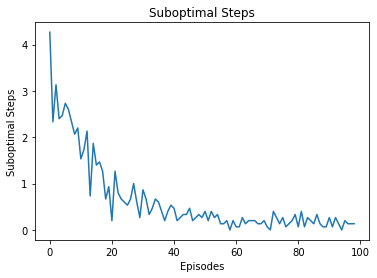

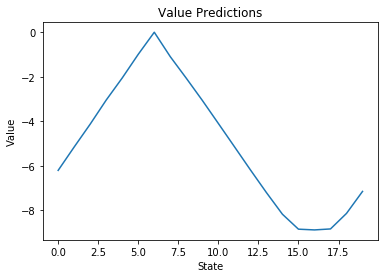

In [33]:
# EVALUATING PERFORMANCE
# calculating average of suboptimal steps
sum = 0
suboptimal_steps_avg_index = 0

for i in range(len(suboptimal_steps)):
	sum += suboptimal_steps[i]
		
	if i % num_items_per_avg == 0 and i != 0:
		suboptimal_steps_avg[suboptimal_steps_avg_index] = sum / num_items_per_avg
		suboptimal_steps_avg_index += 1
		sum = 0

# plotting results
plt.plot(suboptimal_steps_avg)
plt.title('Suboptimal Steps')
plt.xlabel('Episodes')
plt.ylabel('Suboptimal Steps')
plt.show()

plt.plot(current_predictions())
plt.title('Value Predictions')
plt.xlabel('State')
plt.ylabel('Value')
plt.show()